In [2]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm import tqdm

current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../train')

import model._models as models
import datamodule._datamodules as datamodules
import dataset._datasets as datasets
import route._routes as routes
import mylib.utils as ut
import mylib.config as conf

In [3]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
# DF_PATH = os.path.join(ROOT_PATH, "data", "df_test.pickle")
DF_PATH = os.path.join(ROOT_PATH, "data", "df_5s_avg.pickle")
OUTPUT_DIR = os.path.join(ROOT_PATH, "out")
CONFIG_DIR = os.path.join(ROOT_PATH, "config")

In [5]:
def plot_route2(x, y, y_hat):
    # 2つのルートをプロット
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    ax[1].plot(y[0, :, 0], y[0, :, 1], marker="o", label="true")
    ax[1].plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x", label="pred")
    ax[1].set_xlim(0, 3.5)
    ax[1].set_ylim(0, 11)
    ax[1].legend()
    plt.show()

In [6]:
def get_random_noise(mean, std, shape):
    # ランダムノイズを生成
    random_noise = torch.normal(mean=mean, std=std, size=shape)
    # random_noise = torch.empty(x.shape[0], x.shape[1]).uniform_(-0.5, 0.5)
    return random_noise

In [7]:
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\1-2024-09-26-01-42-3ax_zeros")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\2-2024-10-05-08-20-3ax_distance")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\3-2024-09-28-14-23-3ax_route")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\4-2024-10-09-22-42-3ax_route_diff")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\5-2024-10-09-22-34-2ax_zeros_abci")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\6-2024-10-09-22-34-2ax_distance_abci")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\7-2024-10-09-22-34-2ax_route_abci")
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\reuslt\8-2024-10-09-22-34-2ax_route_diff_abci")

exp1_many_array_dirs = [
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_array\2025-01-15-19-02-2ax_distance_index"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_array\2025-01-15-22-05-2ax_route_index"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_array\2025-01-16-01-10-2ax_zeros_index"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_array\2025-01-16-04-12-3ax_distance_index"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_array\2025-01-16-07-15-3ax_route_index"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_array\2025-01-16-10-14-3ax_zeros_index"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_array\2025-01-21-18-24-2ax_routed_index"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_array\2025-01-21-21-25-3ax_routed_index")
]
exp1_many_flat_dirs = [
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_flat\2025-01-18-09-49-2ax_distance_flat"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_flat\2025-01-18-12-47-2ax_route_flat"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\many_flat\2025-01-23-01-04-2ax_zeros_flat")
]
exp1_one_flat_dirs = [
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\one_flat\2025-01-17-15-48-2ax_distance_flat2"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\one_flat\2025-01-17-18-45-2ax_route_flat2"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\one_flat\2025-01-17-21-43-2ax_zeros_flat2"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\one_flat\2025-01-18-00-38-3ax_distance_flat2"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\one_flat\2025-01-18-03-31-3ax_route_flat2"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp1\one_flat\2025-01-18-06-29-3ax_zeros_flat2")
]


exp2_dirs = [
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp2\2025-01-19-08-10-2ax_zeros_index_len_2"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp2\2025-01-19-09-02-2ax_zeros_index_len_5"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp2\2025-01-19-09-56-2ax_zeros_index_len_10"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp2\2025-01-19-10-49-2ax_zeros_index_len_20"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp2\2025-01-19-11-42-2ax_zeros_index_len_40"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp2\2025-01-19-12-36-2ax_zeros_index_len_d20"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp2\2025-01-19-13-11-2ax_zeros_index_len_d10"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp2\2025-01-19-14-19-2ax_zeros_index_len_d5"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp2\2025-01-19-16-33-2ax_zeros_index_len_d2")
]

exp0_flat_dirs = [
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp0\2025-01-18-16-35-2ax_zeros_flat_in80_d64_out40"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp0\2025-01-18-17-27-2ax_zeros_flat_in80_d128_out40"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp0\2025-01-18-18-23-2ax_zeros_flat_in80_d256_out40")
    ]
exp0_array_dirs = [
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp0\2025-01-18-23-13-2ax_zeros_index_d32"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp0\2025-01-19-00-06-2ax_zeros_index_d64"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp0\2025-01-19-01-00-2ax_zeros_index_d128"),
    Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\_exp0\2025-01-19-01-56-2ax_zeros_index_d256")
]




In [8]:
def eval(log_dir, add_noise=False):

    cp_path = os.path.join(log_dir, "cp/best_loss_fold.ckpt")
    config_path = os.path.join(log_dir, "config.yaml")

    ut.fix_seeds(0)
    df = pickle.load(open(DF_PATH, "rb"))
    config = conf.from_yaml(config_path)

    # 各種初期化
    model = models.get_model_with_checkpoint(config["model"], cp_path)
    route_gen = routes.get_route_generator(config["route"])
    dataset = datasets.get_dataset(config["dataset"])
    dm = datamodules.get_dm(config["dm"])

    dataset.set_route(df, route_gen)
    dm.setDataset(dataset)

    fname = config["fname"]


    model.eval()
    loss_list = []
    dist_list = []

    # シーケンスバーでループ
    for i in tqdm(range(len(dm.test_dataset))):
        # batch = dm.train_dataset[i]
        # batch = dm.val_dataset[i]
        batch = dm.test_dataset[i]

        x, y = batch
        x = x.unsqueeze(0).cuda()
        y = y.unsqueeze(0).cuda()

        if add_noise:
            mean = 0.0  # 平均
            std = 0.381  # 標準偏差
            x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
            x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
            x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()

        
        y_hat = model(x)

        loss = nn.functional.mse_loss(y_hat, y)
        loss_list.append(loss.item())


        x = x.cpu().detach().numpy()
        y_hat = y_hat.cpu().detach().numpy()
        y = y.cpu().detach().numpy()
        dist_errors = np.linalg.norm(y - y_hat, axis=-1)
        
        dist_list.append(dist_errors)  

    

    print(np.shape(dist_list))
    dist_array = np.concatenate(dist_list, axis=0) 

    return dist_array, fname


In [9]:
# (batch_size, flat_size) -> (batch_size, dim1, 2) に変換する関数
def unflatten_to_last_two_dims_fixed(tensor):
    # flat_size を取得
    flat_size = tensor.shape[1]
    # dim1 を計算（flat_size を 2 で割る）
    dim1 = flat_size // 2

    # 確認: flat_size が 2 で割り切れる必要がある
    assert flat_size % 2 == 0, "The second dimension must be divisible by 2"
    
    # リシェイプして返す
    return tensor.view(tensor.shape[0], dim1, 2)

In [10]:
def eval_batch(log_dir, add_noise=False, is_flat=False, is_one=False):

    cp_path = os.path.join(log_dir, "cp/best_loss_fold.ckpt")
    config_path = os.path.join(log_dir, "config.yaml")

    ut.fix_seeds(0)
    df = pickle.load(open(DF_PATH, "rb"))
    config = conf.from_yaml(config_path)

    # 各種初期化
    model = models.get_model_with_checkpoint(config["model"], cp_path)
    route_gen = routes.get_route_generator(config["route"])
    dataset = datasets.get_dataset(config["dataset"])
    dm = datamodules.get_dm(config["dm"])

    dataset.set_route(df, route_gen)
    dm.setDataset(dataset)

    fname = config["fname"]


    model.eval()
    loss_list = []
    dist_list = []

    # シーケンスバーでループ
    for batch in tqdm(dm.test_dataloader()):
        # batch = dm.train_dataset[i]
        # batch = dm.val_dataset[i]
        # batch = dm.test_dataset[i]

        x, y = batch
        x, y = x.cuda(), y.cuda()
        # x = x.unsqueeze(0).cuda()
        # y = y.unsqueeze(0).cuda()
        # print(x.shape)
        # print(y.shape)

        if add_noise:
            mean = 0.0  # 平均
            std = 0.381  # 標準偏差
            x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
            x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
            x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
        
        
        if is_flat:
            x = x.view(-1, x.shape[-1] * x.shape[-2])
            y = y.view(-1, y.shape[-1] * y.shape[-2])
            # x, y = x.view(64, -1), y.view(64, -1)
        y_hat = model(x)

        if is_one:
            y = y[:, -2:]
        loss = nn.functional.mse_loss(y_hat, y)
        loss_list.append(loss.item())

        if is_flat:
            x = unflatten_to_last_two_dims_fixed(x)
            y_hat = unflatten_to_last_two_dims_fixed(y_hat)
            y = unflatten_to_last_two_dims_fixed(y)


        x = x.cpu().detach().numpy()
        y_hat = y_hat.cpu().detach().numpy()
        y = y.cpu().detach().numpy()

        

        # print(y[0])
        # print(y_hat[0])
        # print((y-y_hat)[0])
        for diff in (y-y_hat):
            dist_errors = np.linalg.norm(diff, axis=-1)
            dist_list.append(dist_errors)
            # print(np.shape(dist_list))

        # dist_errors = np.linalg.norm(y - y_hat, axis=-1)
        # print(np.shape(dist_errors))
        # dist_list.append(dist_errors)  

    
    # return dist_list, fname
    # print(np.shape(dist_list))
    dist_array = np.concatenate(dist_list, axis=0) 

    return dist_array, fname



In [25]:
def plot_route(y, y_hat, title):
    plt.figure(figsize=(10, 4))
    plt.plot(y[ :, 1], y[ :, 0], marker="o", label="true")
    plt.plot(y_hat[ :, 1], y_hat[ :, 0], marker="x", label="pred")
    plt.legend()
    plt.title(title)
    plt.ylim(0, 3.5)
    plt.xlim(0, 11)
    plt.show()

In [31]:
def eval_batch_show(log_dir, add_noise=False, is_flat=False, is_one=False, spot=-1):

    cp_path = os.path.join(log_dir, "cp/best_loss_fold.ckpt")
    config_path = os.path.join(log_dir, "config.yaml")

    ut.fix_seeds(0)
    df = pickle.load(open(DF_PATH, "rb"))
    config = conf.from_yaml(config_path)

    # 各種初期化
    model = models.get_model_with_checkpoint(config["model"], cp_path)
    route_gen = routes.get_route_generator(config["route"])
    dataset = datasets.get_dataset(config["dataset"])
    dm = datamodules.get_dm(config["dm"])

    dataset.set_route(df, route_gen)
    dm.setDataset(dataset)

    fname = config["fname"]


    model.eval()
    loss_list = []
    dist_list = []

    i = 0

    # シーケンスバーでループ
    for batch in tqdm(dm.test_dataloader()):
    
        i += 1
        x, y = batch
        x, y = x.cuda(), y.cuda()

        if add_noise:
            mean = 0.0  # 平均
            std = 0.381  # 標準偏差
            x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
            x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
            x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
        
        
        if is_flat:
            x = x.view(-1, x.shape[-1] * x.shape[-2])
            y = y.view(-1, y.shape[-1] * y.shape[-2])
            # x, y = x.view(64, -1), y.view(64, -1)
        y_hat = model(x)

        if is_one:
            y = y[:, -2:]
        loss = nn.functional.mse_loss(y_hat, y)
        loss_list.append(loss.item())

        if is_flat:
            x = unflatten_to_last_two_dims_fixed(x)
            y_hat = unflatten_to_last_two_dims_fixed(y_hat)
            y = unflatten_to_last_two_dims_fixed(y)


        x = x.cpu().detach().numpy()
        y_hat = y_hat.cpu().detach().numpy()
        y = y.cpu().detach().numpy()

        # print(np.shape(y), np.shape(y_hat))
        # print(np.shape(y[0]), np.shape(y_hat[0]))
        
        if i == spot:
            if add_noise:
                plot_route(y[0], y_hat[0], fname + " noise")
            else:
                plot_route(y[0], y_hat[0], fname)
        # plot_route(y[0], y_hat[0])



    

    return fname



In [35]:
def eval_batch_saver(log_dir, add_noise=False, is_flat=False, is_one=False, spot=-1):

    cp_path = os.path.join(log_dir, "cp/best_loss_fold.ckpt")
    config_path = os.path.join(log_dir, "config.yaml")

    ut.fix_seeds(0)
    df = pickle.load(open(DF_PATH, "rb"))
    config = conf.from_yaml(config_path)

    # 各種初期化
    model = models.get_model_with_checkpoint(config["model"], cp_path)
    route_gen = routes.get_route_generator(config["route"])
    dataset = datasets.get_dataset(config["dataset"])
    dm = datamodules.get_dm(config["dm"])

    dataset.set_route(df, route_gen)
    dm.setDataset(dataset)

    fname = config["fname"]


    model.eval()
    loss_list = []
    dist_list = []

    i = 0

    # シーケンスバーでループ
    for batch in tqdm(dm.test_dataloader()):
    
        i += 1
        
        x, y = batch
        x, y = x.cuda(), y.cuda()

        if add_noise:
            mean = 0.0  # 平均
            std = 0.381  # 標準偏差
            x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
            x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
            x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
        
        
        if is_flat:
            x = x.view(-1, x.shape[-1] * x.shape[-2])
            y = y.view(-1, y.shape[-1] * y.shape[-2])
            # x, y = x.view(64, -1), y.view(64, -1)
        y_hat = model(x)

        if is_one:
            y = y[:, -2:]
        loss = nn.functional.mse_loss(y_hat, y)
        loss_list.append(loss.item())

        if is_flat:
            x = unflatten_to_last_two_dims_fixed(x)
            y_hat = unflatten_to_last_two_dims_fixed(y_hat)
            y = unflatten_to_last_two_dims_fixed(y)


        x = x.cpu().detach().numpy()
        y_hat = y_hat.cpu().detach().numpy()
        y = y.cpu().detach().numpy()

        # print(np.shape(y), np.shape(y_hat))
        # print(np.shape(y[0]), np.shape(y_hat[0]))
        
        if i == spot:
            if add_noise:
                plot_route(y[0], y_hat[0], fname + " noise")
            else:
                plot_route(y[0], y_hat[0], fname)
            return batch, fname
        # plot_route(y[0], y_hat[0])



    

    return fname



In [48]:
def eval_batch_force_2ax(log_dir, batch, add_noise=False, is_flat=False, is_one=False):

    cp_path = os.path.join(log_dir, "cp/best_loss_fold.ckpt")
    config_path = os.path.join(log_dir, "config.yaml")

    ut.fix_seeds(0)
    df = pickle.load(open(DF_PATH, "rb"))
    config = conf.from_yaml(config_path)

    # 各種初期化
    model = models.get_model_with_checkpoint(config["model"], cp_path)
    # route_gen = routes.get_route_generator(config["route"])
    # dataset = datasets.get_dataset(config["dataset"])
    # dm = datamodules.get_dm(config["dm"])

    # dataset.set_route(df, route_gen)
    # dm.setDataset(dataset)

    fname = config["fname"]


    model.eval()

    x, y = batch
    x, y = x.cuda(), y.cuda()




    if add_noise:
        mean = 0.0  # 平均
        std = 0.381  # 標準偏差
        x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
        x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
        x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
    
    # force 2ax
    x[:, :, 0] = torch.sqrt(x[:, :, 0]**2 + x[:, :, 1]**2)
    x = torch.cat((x[:, :, :1], x[:, :, 2:]), dim=2)


    if is_flat:
        x = x.view(-1, x.shape[-1] * x.shape[-2])
        y = y.view(-1, y.shape[-1] * y.shape[-2])
        # x, y = x.view(64, -1), y.view(64, -1)
    y_hat = model(x)

    if is_one:
        y = y[:, -2:]

    if is_flat:
        x = unflatten_to_last_two_dims_fixed(x)
        y_hat = unflatten_to_last_two_dims_fixed(y_hat)
        y = unflatten_to_last_two_dims_fixed(y)


    x = x.cpu().detach().numpy()
    y_hat = y_hat.cpu().detach().numpy()
    y = y.cpu().detach().numpy()

    # print(np.shape(y), np.shape(y_hat))
    # print(np.shape(y[0]), np.shape(y_hat[0]))
    
    if add_noise:
        plot_route(y[0], y_hat[0], fname + " noise")
    else:
        plot_route(y[0], y_hat[0], fname)
    # plot_route(y[0], y_hat[0])

    return fname



  3%|▎         | 1/32 [00:29<15:03, 29.15s/it]

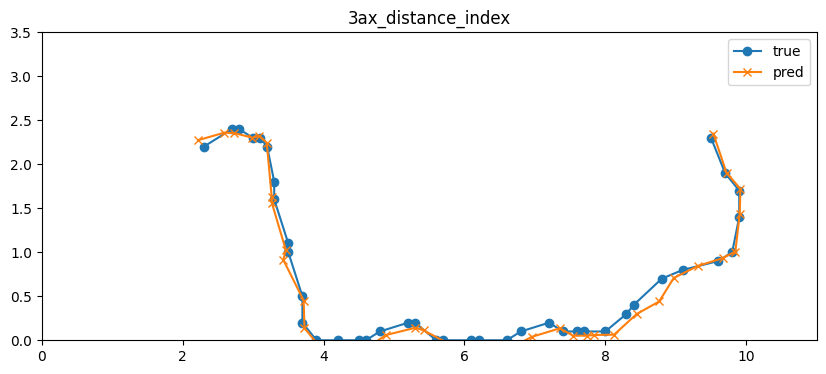

  3%|▎         | 1/32 [00:28<14:45, 28.57s/it]

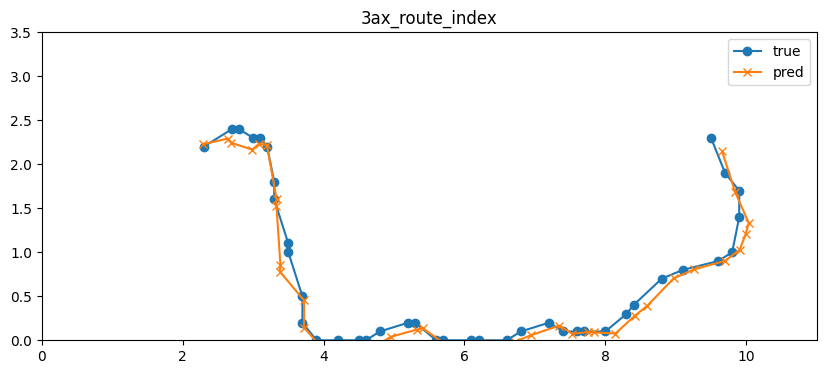

 12%|█▎        | 4/32 [00:29<02:38,  5.68s/it]

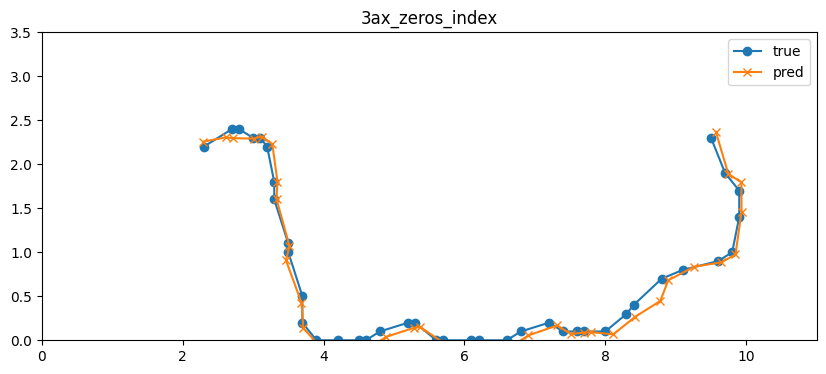

  3%|▎         | 1/32 [00:29<15:11, 29.42s/it]

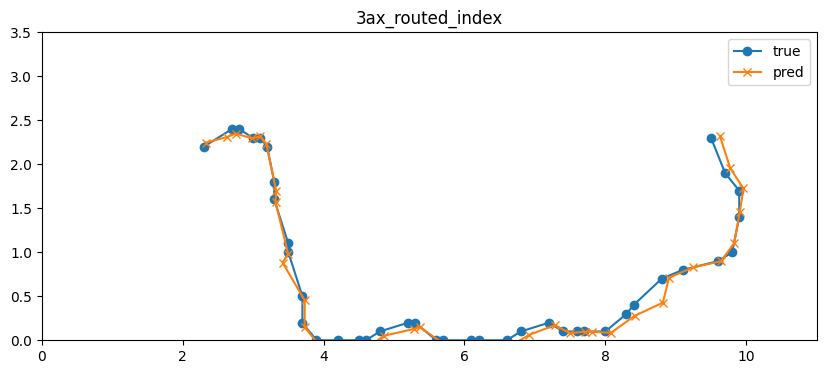

 12%|█▎        | 4/32 [00:29<03:27,  7.41s/it]


In [42]:
saved_batch_distance, fname_distance = eval_batch_saver(exp1_many_array_dirs[3], spot=5)
saved_batch_route, fname_route = eval_batch_saver(exp1_many_array_dirs[4], spot=5)
saved_batch_zeros, fname_zeros = eval_batch_saver(exp1_many_array_dirs[5], spot=5)
saved_batch_routed, fname_routed = eval_batch_saver(exp1_many_array_dirs[7], spot=5)

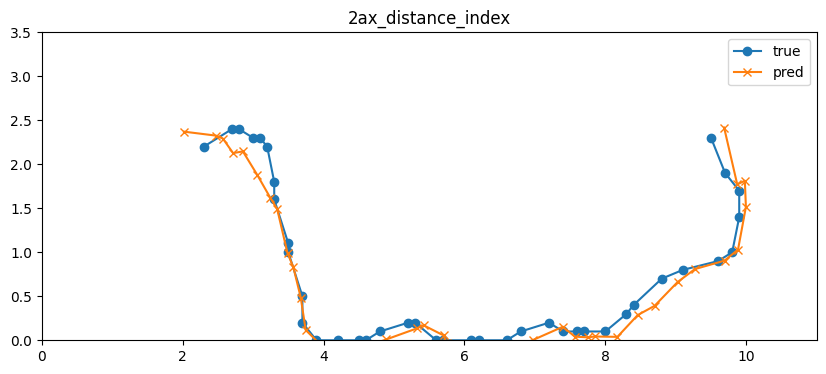

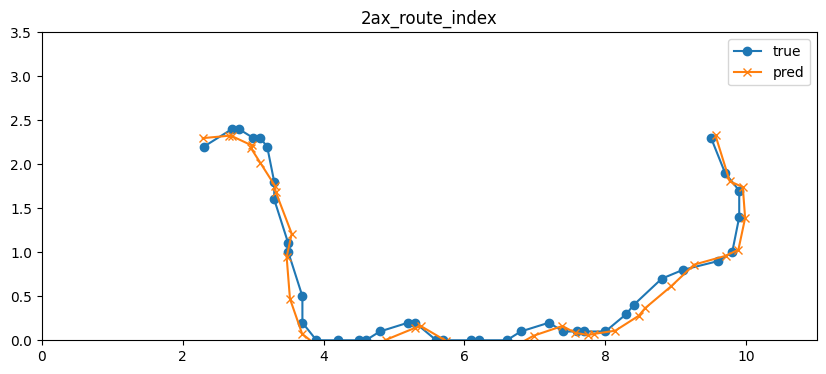

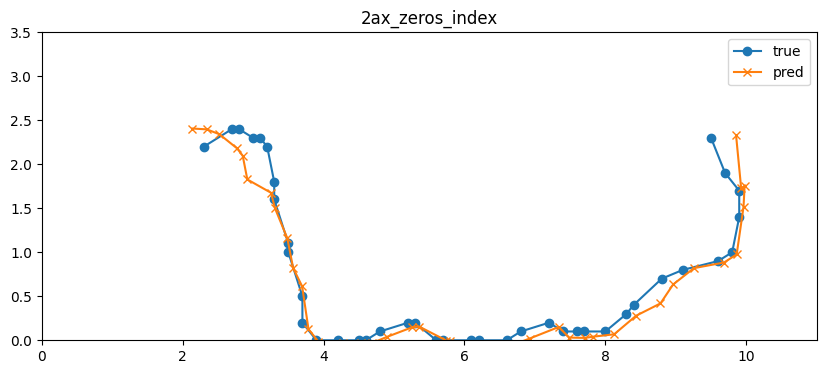

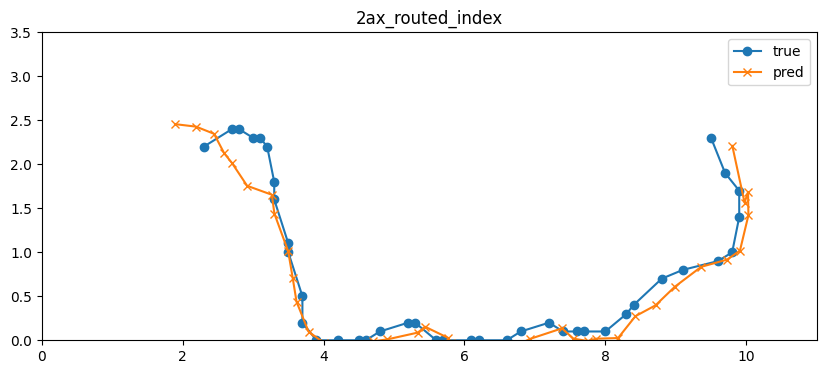

'2ax_routed_index'

In [50]:
# saved_batch_distance, fname_distance = eval_batch_saver(exp1_many_array_dirs[3], spot=5)
# saved_batch_route, fname_route = eval_batch_saver(exp1_many_array_dirs[4], spot=5)
# saved_batch_zeros, fname_zeros = eval_batch_saver(exp1_many_array_dirs[5], spot=5)
# saved_batch_routed, fname_routed = eval_batch_saver(exp1_many_array_dirs[7], spot=5)
eval_batch_force_2ax(exp1_many_array_dirs[0], saved_batch_distance)
eval_batch_force_2ax(exp1_many_array_dirs[1], saved_batch_route)
eval_batch_force_2ax(exp1_many_array_dirs[2], saved_batch_zeros)
eval_batch_force_2ax(exp1_many_array_dirs[6], saved_batch_routed)

  3%|▎         | 1/32 [00:29<15:27, 29.91s/it]

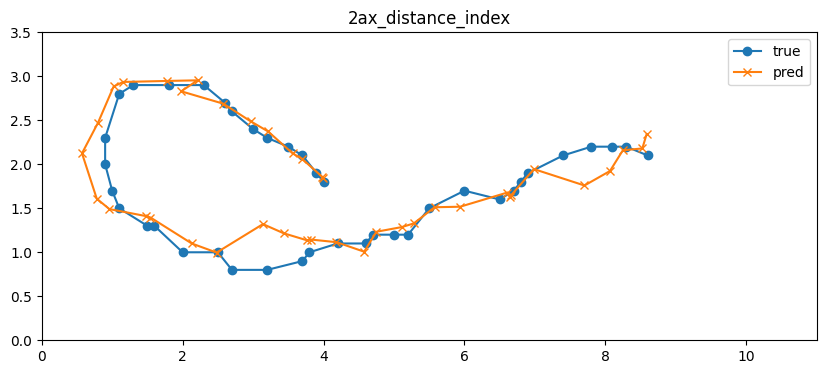

100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


2ax_distance_index


 12%|█▎        | 4/32 [00:30<02:40,  5.72s/it]

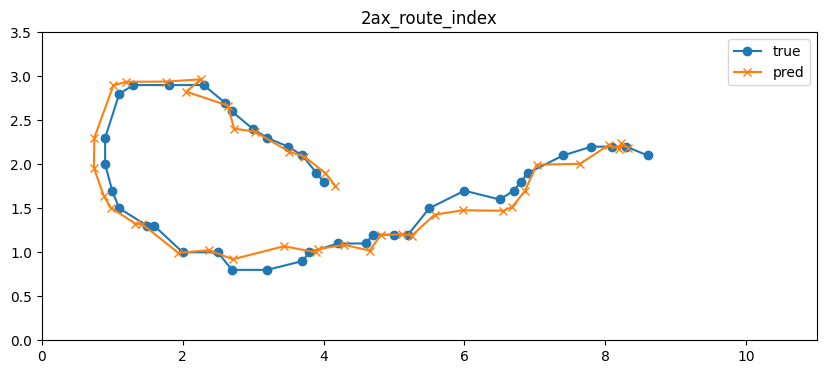

100%|██████████| 32/32 [00:30<00:00,  1.05it/s]


2ax_route_index


  9%|▉         | 3/32 [00:32<04:03,  8.39s/it]

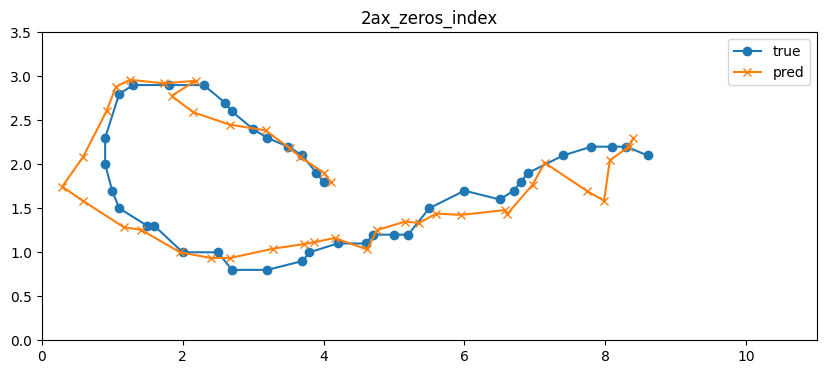

100%|██████████| 32/32 [00:32<00:00,  1.02s/it]


2ax_zeros_index


  3%|▎         | 1/32 [00:36<19:02, 36.85s/it]

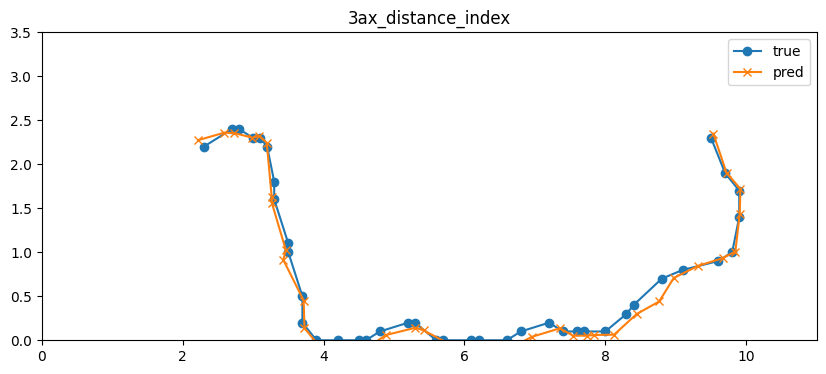

100%|██████████| 32/32 [00:37<00:00,  1.16s/it]


3ax_distance_index


  9%|▉         | 3/32 [00:37<04:41,  9.69s/it]

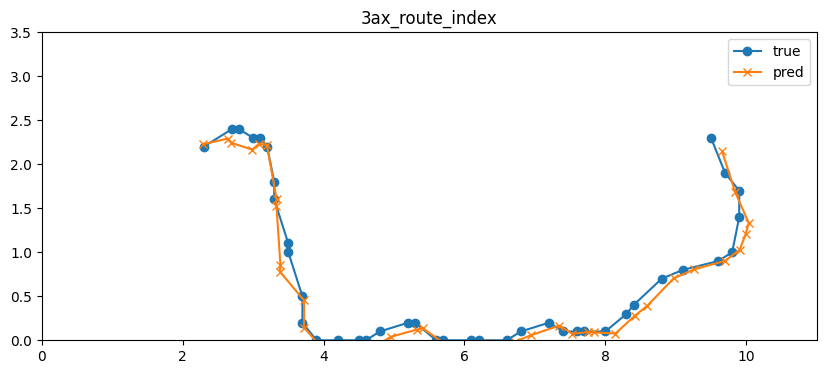

100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


3ax_route_index


  6%|▋         | 2/32 [00:37<07:40, 15.34s/it]

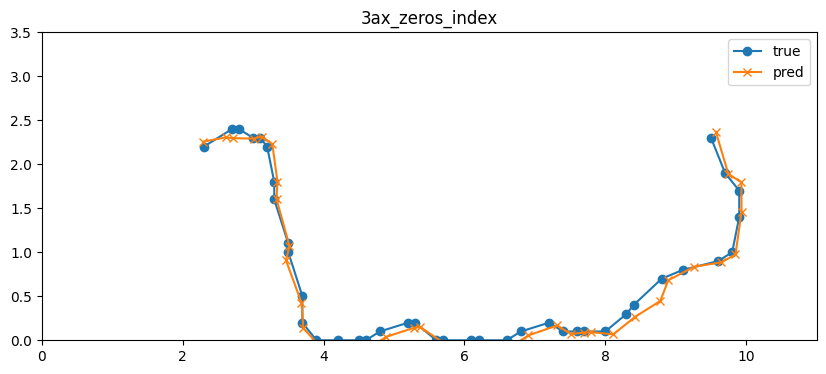

100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


3ax_zeros_index


  3%|▎         | 1/32 [00:37<19:17, 37.33s/it]

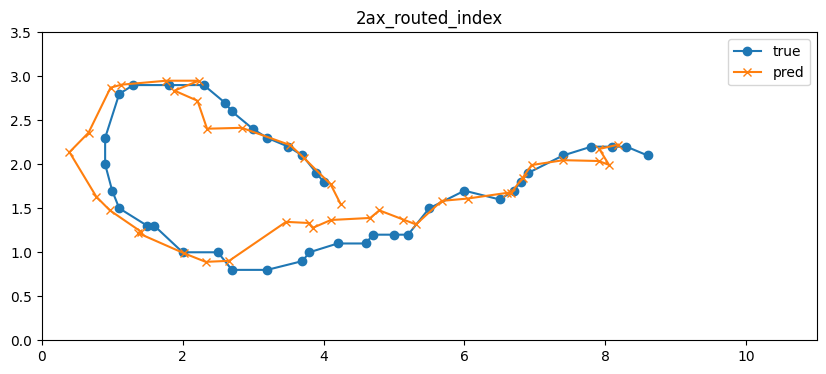

100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


2ax_routed_index


  6%|▋         | 2/32 [00:37<07:46, 15.54s/it]

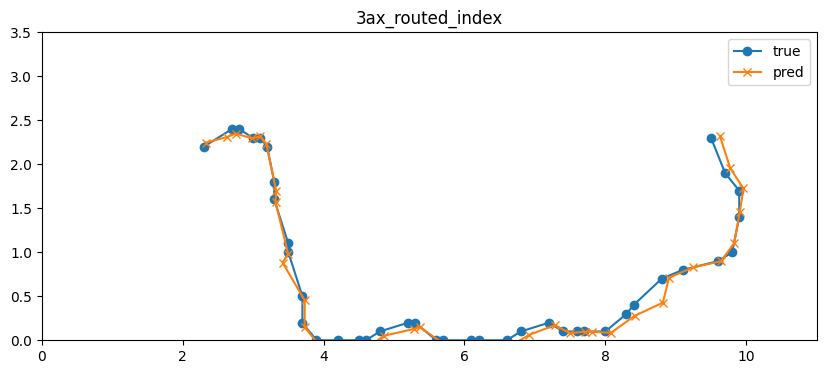

100%|██████████| 32/32 [00:37<00:00,  1.19s/it]


3ax_routed_index


In [29]:
for log_dir in exp1_many_array_dirs:
    fname = eval_batch_show(log_dir, spot=5)
    print(fname)

 12%|█▎        | 4/32 [00:37<02:40,  5.71s/it]

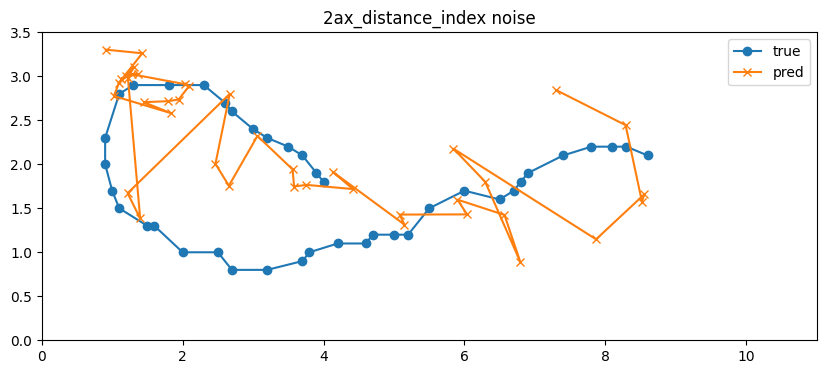

100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


2ax_distance_index


  9%|▉         | 3/32 [00:37<04:41,  9.70s/it]

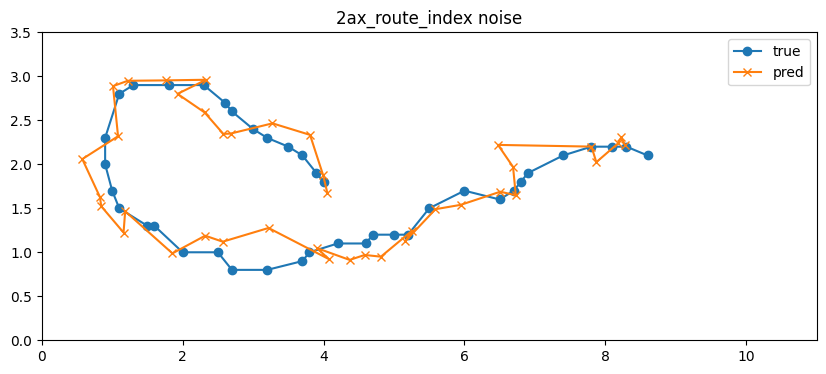

100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


2ax_route_index


 12%|█▎        | 4/32 [00:37<03:17,  7.07s/it]

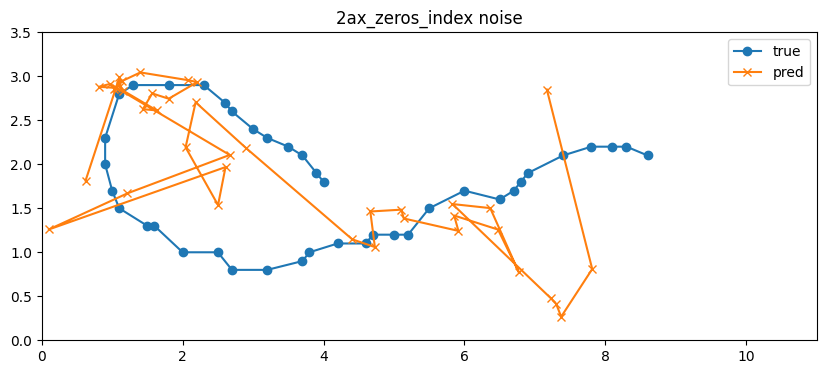

100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


2ax_zeros_index


  3%|▎         | 1/32 [00:37<19:14, 37.24s/it]

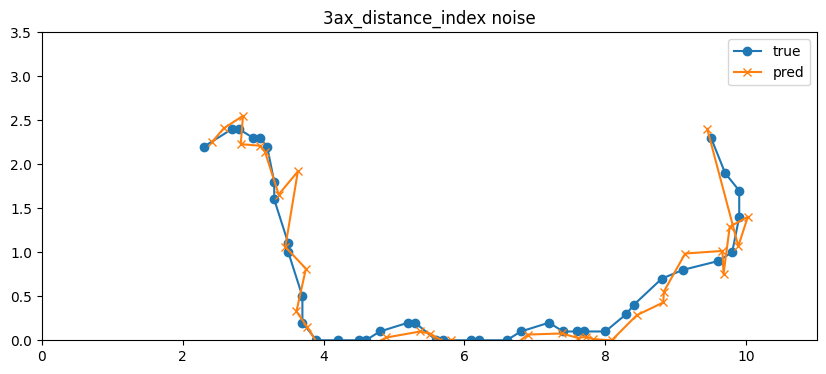

100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


3ax_distance_index


  3%|▎         | 1/32 [00:37<19:17, 37.35s/it]

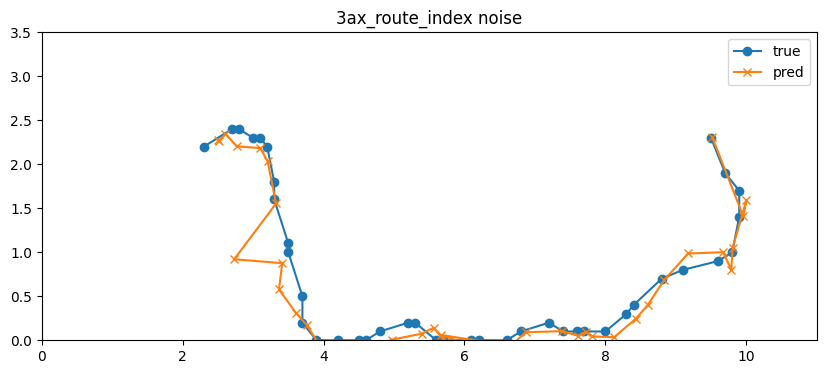

100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


3ax_route_index


  6%|▋         | 2/32 [00:37<07:42, 15.42s/it]

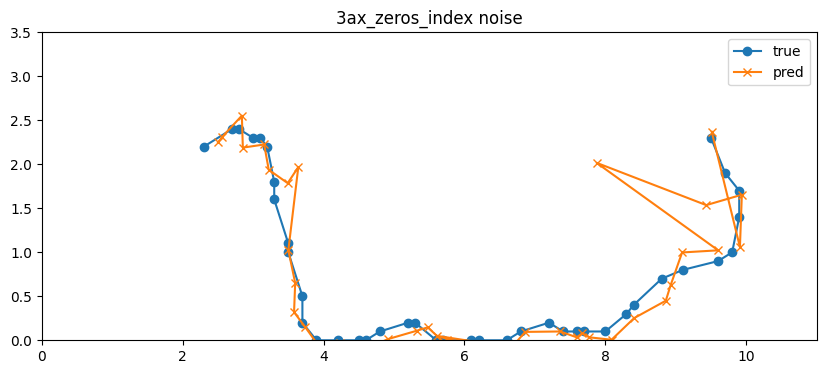

100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


3ax_zeros_index


  9%|▉         | 3/32 [00:37<04:43,  9.77s/it]

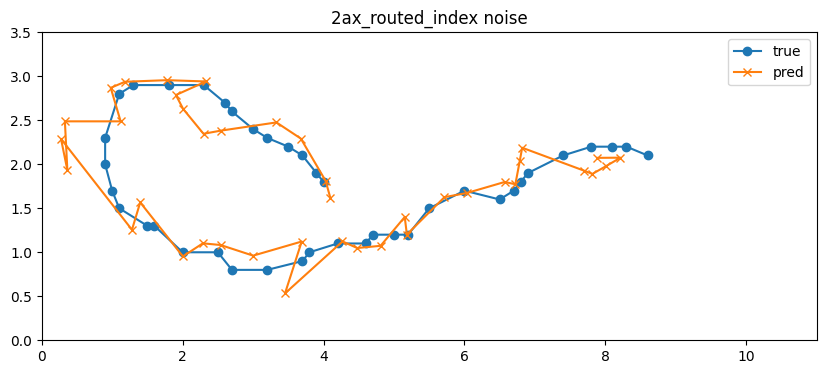

100%|██████████| 32/32 [00:37<00:00,  1.18s/it]


2ax_routed_index


  6%|▋         | 2/32 [00:36<07:37, 15.25s/it]

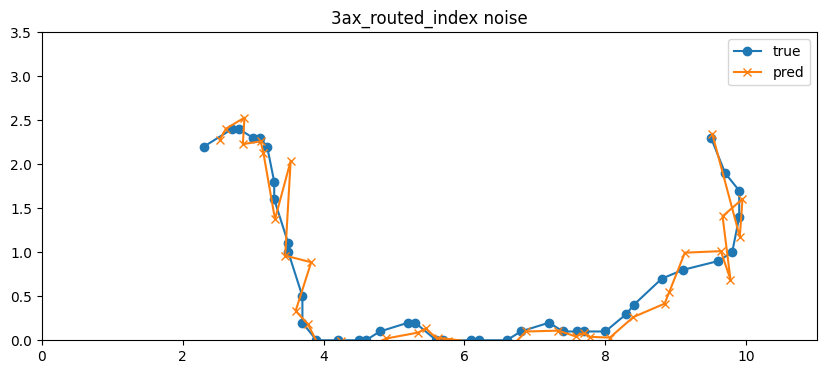

100%|██████████| 32/32 [00:37<00:00,  1.17s/it]


3ax_routed_index


In [32]:
for log_dir in exp1_many_array_dirs:
    fname = eval_batch_show(log_dir, add_noise=True, spot=5)
    print(fname)

In [ ]:
# fname_list = []
# for log_dir in exp1_many_array_dirs:
#     dist_array, fname = eval(log_dir, False)
#     print(fname)
#     pickle.dump(dist_array, open(f"out/{fname}.pickle", "wb"))
#     fname_list.append(fname)


In [54]:
# for log_dir in exp1_many_array_dirs:
#     dist_array, fname = eval_batch(log_dir)
#     print(fname)
#     pickle.dump(dist_array, open(f"out/{fname}.pickle", "wb"))
#     print(np.mean(dist_array))

for log_dir in exp1_many_flat_dirs:
    dist_array, fname = eval_batch(log_dir, is_flat=True)
    print(fname)
    pickle.dump(dist_array, open(f"out/{fname}.pickle", "wb"))
    print(np.mean(dist_array))

# for log_dir in exp1_one_flat_dirs:
#     dist_array, fname = eval_batch(log_dir, is_flat=True, is_one=True)
#     print(fname)
#     pickle.dump(dist_array, open(f"out/{fname}.pickle", "wb"))
#     print(np.mean(dist_array))

100%|██████████| 32/32 [00:29<00:00,  1.07it/s]


2ax_distance_flat
0.75013304


100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


2ax_route_flat
0.8102277


100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


2ax_zeros_flat
0.810728


In [55]:
# for log_dir in exp1_many_array_dirs:
#     dist_array, fname = eval_batch(log_dir, add_noise=True)
#     print(fname)
#     pickle.dump(dist_array, open(f"out/noise_{fname}.pickle", "wb"))
#     print(np.mean(dist_array))

for log_dir in exp1_many_flat_dirs:
    dist_array, fname = eval_batch(log_dir, add_noise=True, is_flat=True)
    print(fname)
    pickle.dump(dist_array, open(f"out/noise_{fname}.pickle", "wb"))
    print(np.mean(dist_array))

# for log_dir in exp1_one_flat_dirs:
#     dist_array, fname = eval_batch(log_dir, add_noise=True, is_flat=True, is_one=True)
#     print(fname)
#     pickle.dump(dist_array, open(f"out/noise_{fname}.pickle", "wb"))
#     print(np.mean(dist_array))

100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


2ax_distance_flat
1.8675048


100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


2ax_route_flat
0.81680954


100%|██████████| 32/32 [00:29<00:00,  1.07it/s]


2ax_zeros_flat
0.8213209


In [58]:
for log_dir in exp2_dirs:
    dist_array, fname = eval_batch(log_dir)
    print(fname)
    pickle.dump(dist_array, open(f"out/exp2/{fname}.pickle", "wb"))
    print(np.mean(dist_array))

100%|██████████| 32/32 [00:28<00:00,  1.12it/s]


2ax_zeros_index_len_2
0.70514417


100%|██████████| 32/32 [00:27<00:00,  1.16it/s]


2ax_zeros_index_len_5
0.4430321


100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


2ax_zeros_index_len_10
0.3092936


100%|██████████| 32/32 [00:28<00:00,  1.11it/s]


2ax_zeros_index_len_20
0.22450803


100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


2ax_zeros_index_len_40
0.18766785


100%|██████████| 63/63 [00:29<00:00,  2.15it/s]


2ax_zeros_index_len_d20
0.25560775


100%|██████████| 125/125 [00:29<00:00,  4.24it/s]


2ax_zeros_index_len_d10
0.23402695


100%|██████████| 250/250 [00:30<00:00,  8.33it/s]


2ax_zeros_index_len_d5
0.32816863


100%|██████████| 625/625 [00:32<00:00, 19.45it/s] 


2ax_zeros_index_len_d2
0.5349358


In [61]:
for log_dir in exp0_flat_dirs:
    dist_array, fname = eval_batch(log_dir, is_flat=True)
    print(fname)
    pickle.dump(dist_array, open(f"out/exp0/{fname}.pickle", "wb"))
    print(np.mean(dist_array))

for log_dir in exp0_array_dirs:
    dist_array, fname = eval_batch(log_dir)
    print(fname)
    pickle.dump(dist_array, open(f"out/exp0/{fname}.pickle", "wb"))
    print(np.mean(dist_array))

100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


2ax_zeros_flat_in80_d64_out40
0.62192786


100%|██████████| 32/32 [00:30<00:00,  1.06it/s]


2ax_zeros_flat_in80_d128_out40
0.6580312


100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


2ax_zeros_flat_in80_d256_out40
2.8438852


100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


2ax_zeros_index_d32
0.20727003


100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


2ax_zeros_index_d64
0.18766785


100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


2ax_zeros_index_d128
0.19666079


100%|██████████| 32/32 [00:29<00:00,  1.09it/s]


2ax_zeros_index_d256
0.81569314


In [66]:
def create_boxplot(t, data, title):
    # 箱ひげ図を作成
    d = data[t-1: t+2]
    # plt.boxplot(data[t-1: t+2], vert=True, showmeans=True, showfliers=False, labels=["mf", "mf+d", "mf+dydx"], widths=0.5)
    plt.boxplot(d[::-1], vert=False, showmeans=True, showfliers=False, labels=["mf+dydx", "mf+d", "mf"], widths=0.5)
    # plt.ylim(0, 1.85)
    plt.xlim(0, 1.85)
    plt.title(title)
    plt.show()

C:\TEMP\ipykernel_15840\1326822068.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(d[::-1], vert=False, showmeans=True, showfliers=False, labels=["mf+dydx", "mf+d", "mf"], widths=0.5)


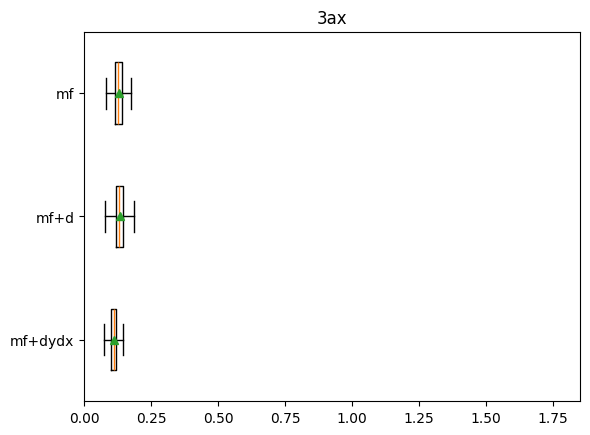

C:\TEMP\ipykernel_15840\1326822068.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(d[::-1], vert=False, showmeans=True, showfliers=False, labels=["mf+dydx", "mf+d", "mf"], widths=0.5)


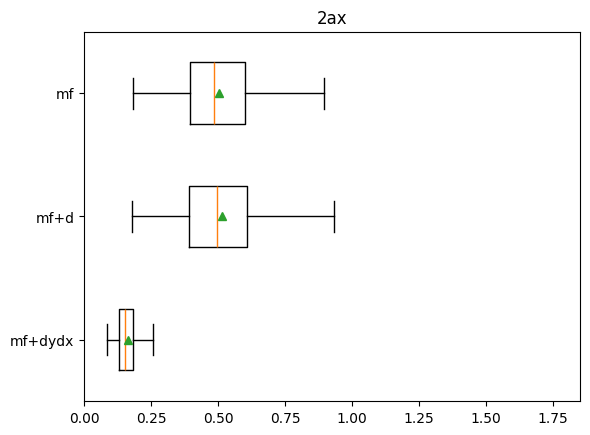

C:\TEMP\ipykernel_15840\1326822068.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(d[::-1], vert=False, showmeans=True, showfliers=False, labels=["mf+dydx", "mf+d", "mf"], widths=0.5)


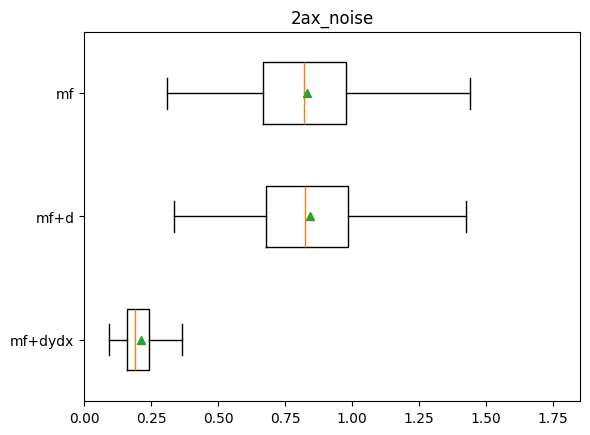

C:\TEMP\ipykernel_15840\1326822068.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(d[::-1], vert=False, showmeans=True, showfliers=False, labels=["mf+dydx", "mf+d", "mf"], widths=0.5)


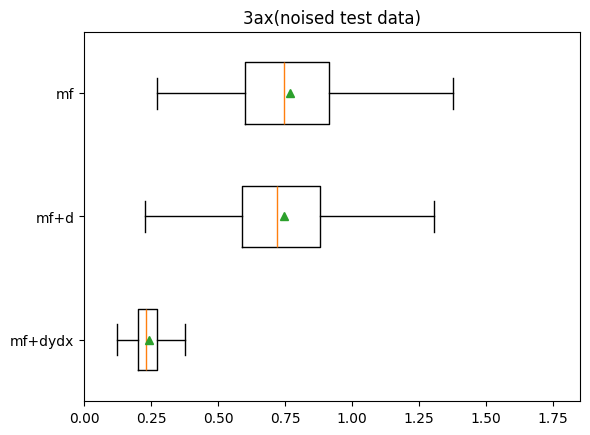

C:\TEMP\ipykernel_15840\1326822068.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(d[::-1], vert=False, showmeans=True, showfliers=False, labels=["mf+dydx", "mf+d", "mf"], widths=0.5)


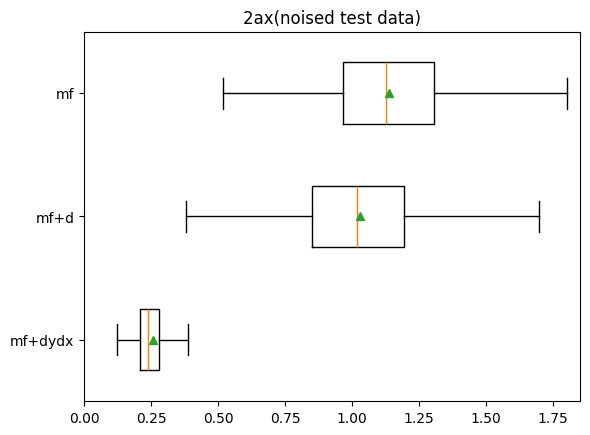

C:\TEMP\ipykernel_15840\1326822068.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(d[::-1], vert=False, showmeans=True, showfliers=False, labels=["mf+dydx", "mf+d", "mf"], widths=0.5)


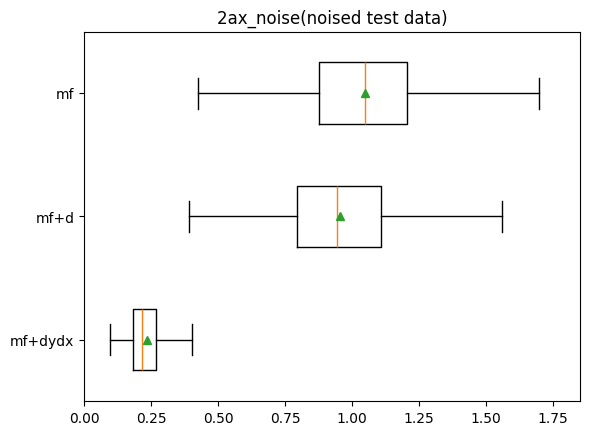

In [67]:
create_boxplot(1, dist_list_list, "3ax")
create_boxplot(5, dist_list_list, "2ax")
create_boxplot(9, dist_list_list, "2ax_noise")


create_boxplot(1, dist_list_list_noise, "3ax(noised test data)")
create_boxplot(5, dist_list_list_noise, "2ax(noised test data)")
create_boxplot(9, dist_list_list_noise, "2ax_noise(noised test data)")

In [10]:
def fig_data(log_dir, add_noise=False):

    cp_path = os.path.join(log_dir, "cp/best_loss_fold.ckpt")
    config_path = os.path.join(log_dir, "config.yaml")

    ut.fix_seeds(0)
    df = pickle.load(open(DF_PATH, "rb"))
    config = conf.from_yaml(config_path)

    # 各種初期化
    model = models.get_model_with_checkpoint(config["model"], cp_path)
    route_gen = routes.get_route_generator(config["route"])
    dataset = datasets.get_dataset(config["dataset"])
    dm = datamodules.get_dm(config["dm"])

    dataset.set_route(df, route_gen)
    dm.setDataset(dataset)


    model.eval()
    loss_list = []
    dist_list = []

    i = 214

    batch = dm.test_dataset[i]

    x, y = batch
    x = x.unsqueeze(0).cuda()
    y = y.unsqueeze(0).cuda()

    if add_noise:
        mean = 0.0  # 平均
        std = 0.381  # 標準偏差
        x[:, :, 0] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
        x[:, :, 1] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()
        x[:, :, 2] += get_random_noise(mean, std, (x.shape[0], x.shape[1])).cuda()

    
    y_hat = model(x)

    loss = nn.functional.mse_loss(y_hat, y)
    loss_list.append(loss.item())


    x = x.cpu().detach().numpy()
    y_hat = y_hat.cpu().detach().numpy()
    y = y.cpu().detach().numpy()

    return x, y, y_hat

In [11]:
fig_datas = []
fig_datas_noise = []
for i, log_dir in enumerate(log_dirs[:]):
    print(i)
    fig_datas.append(fig_data(log_dir, False))
    fig_datas_noise.append(fig_data(log_dir, True))


0
1
2
3
4
5
6
7
8
9
10
11


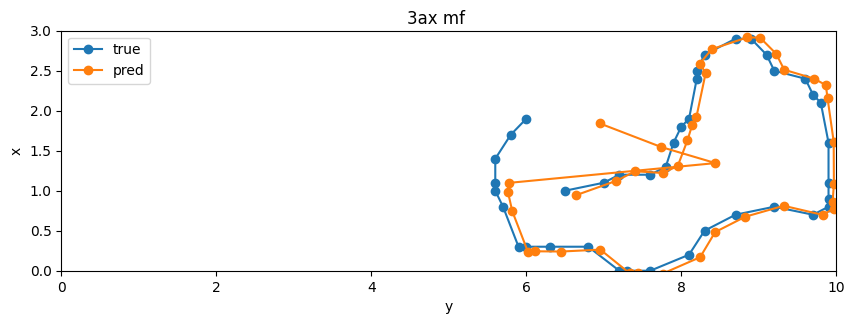

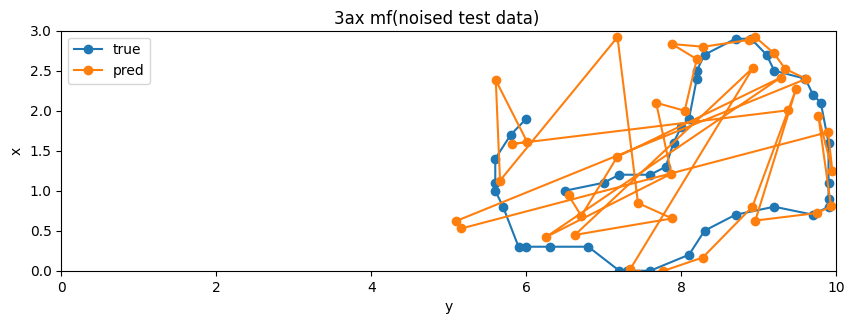

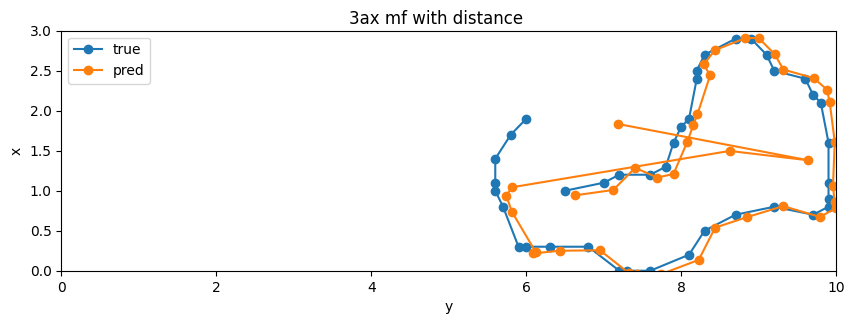

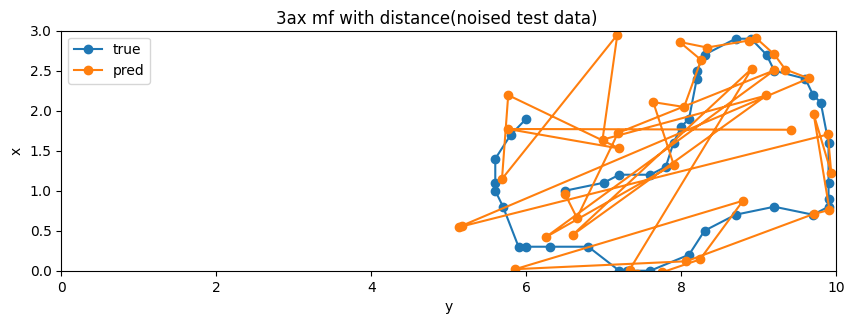

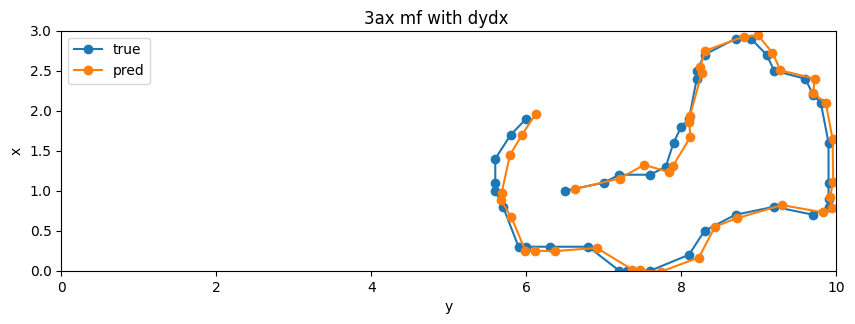

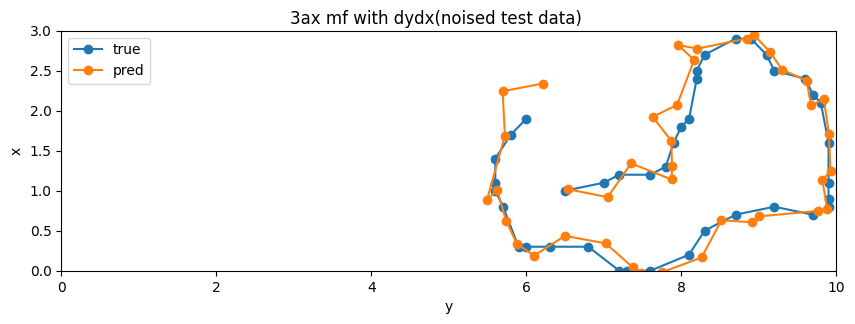

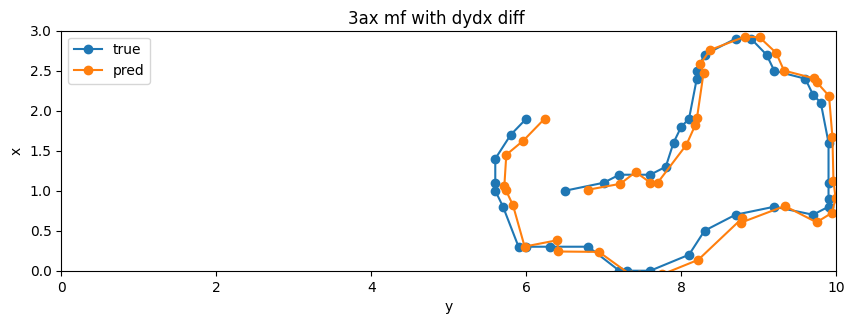

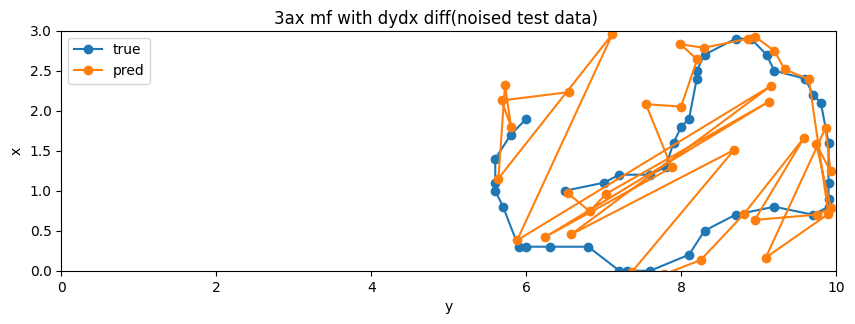

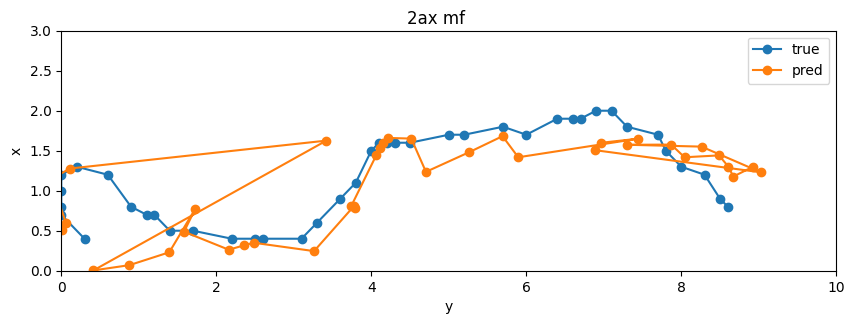

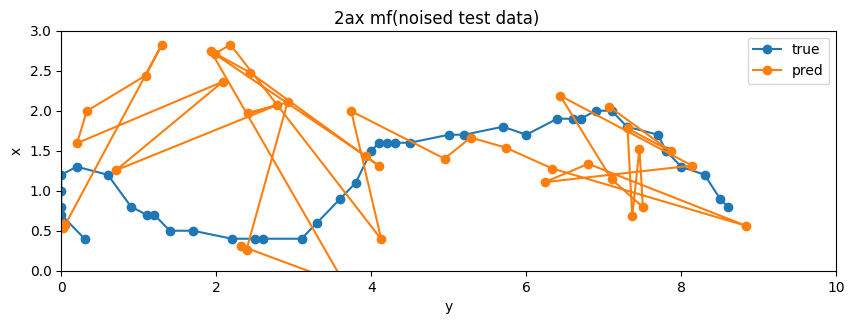

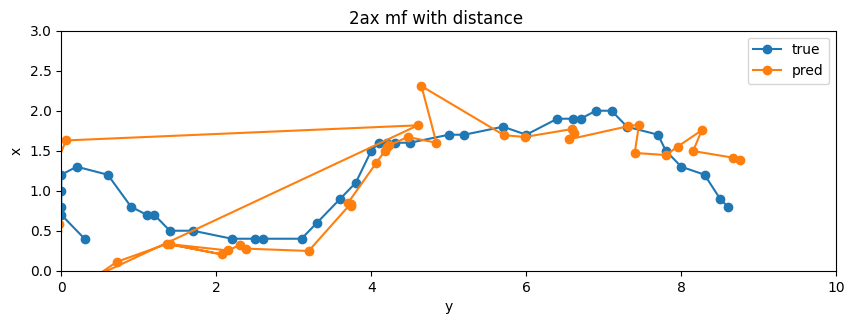

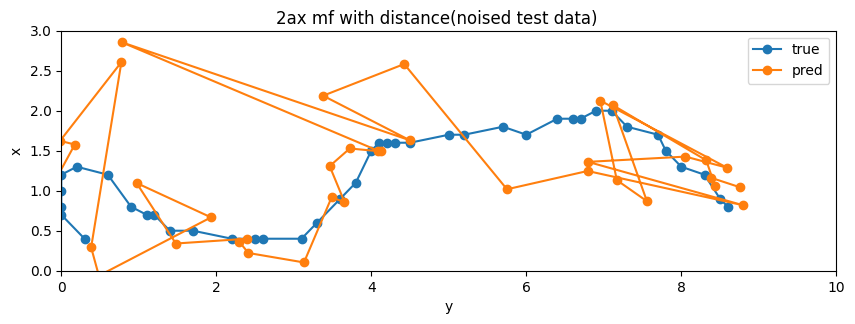

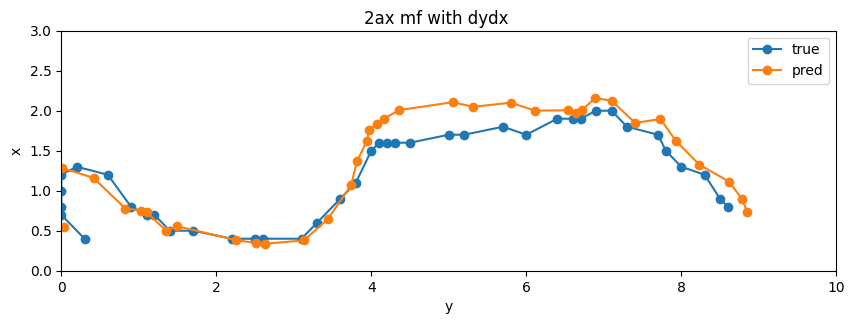

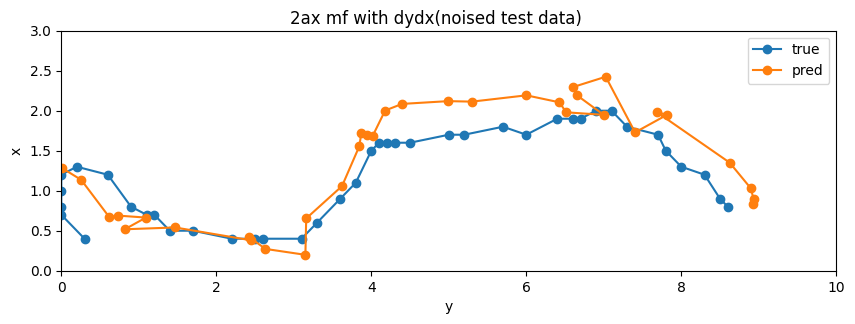

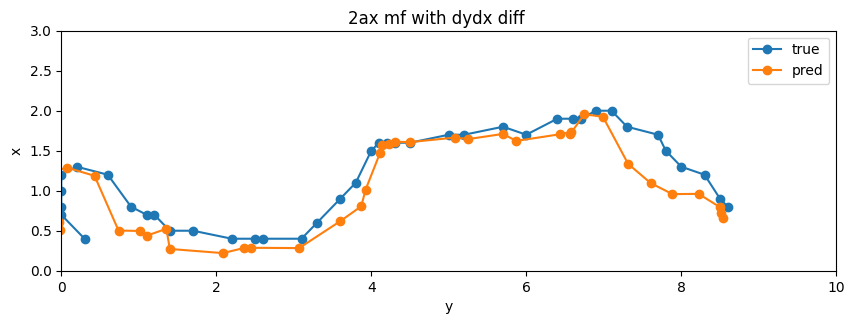

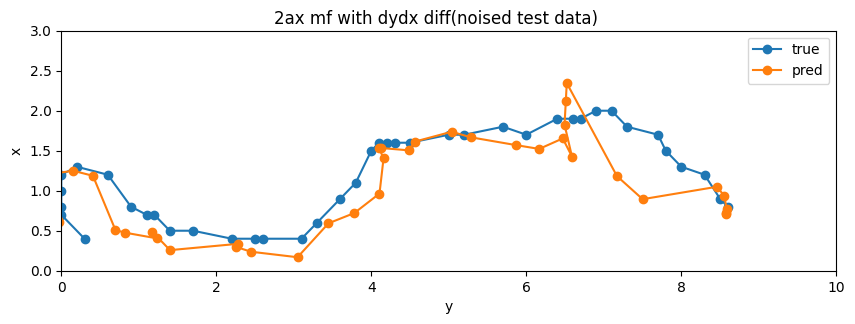

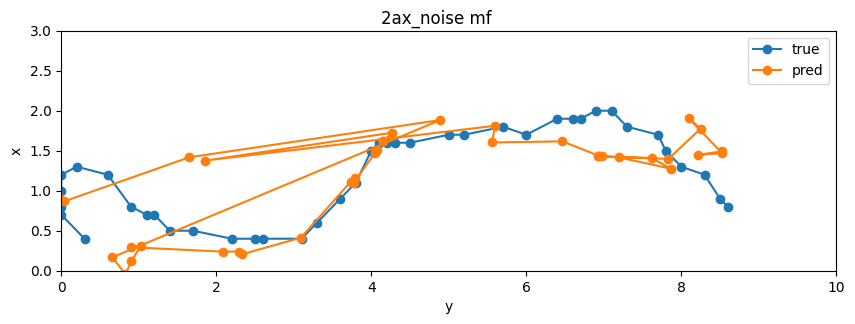

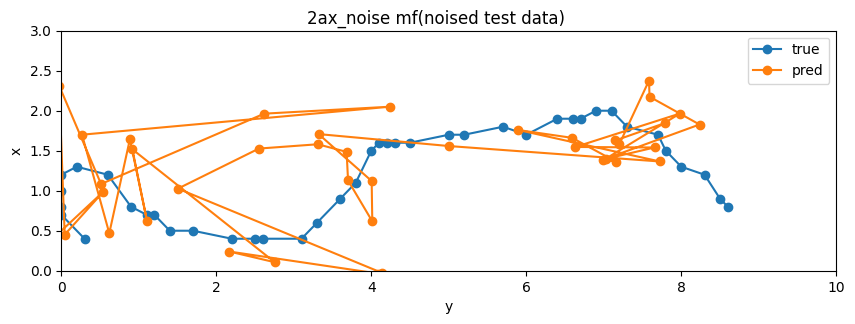

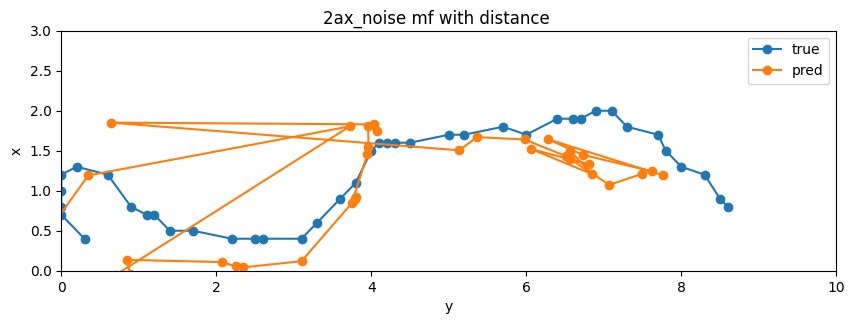

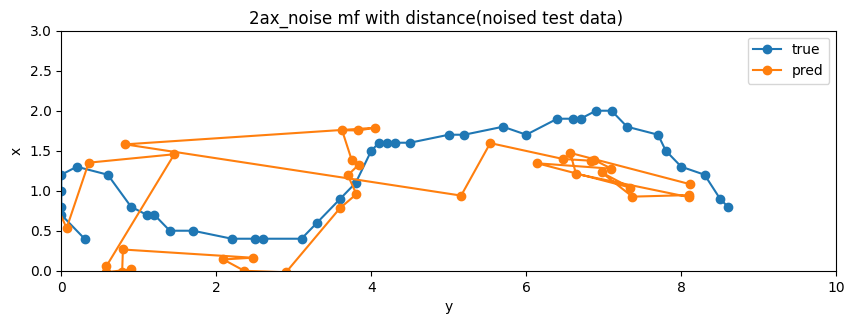

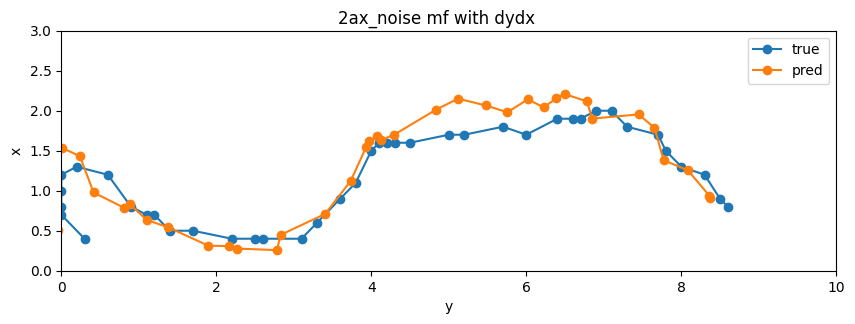

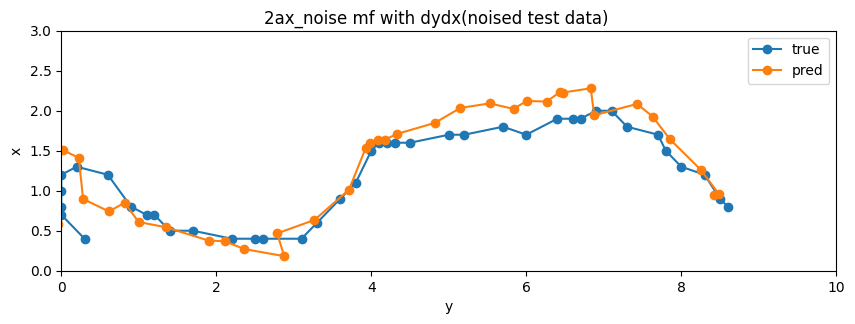

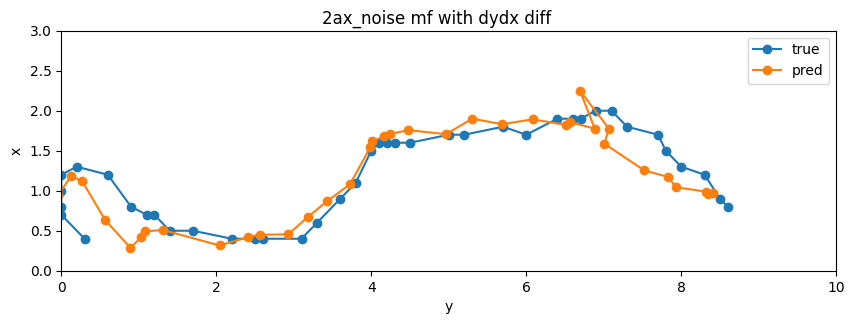

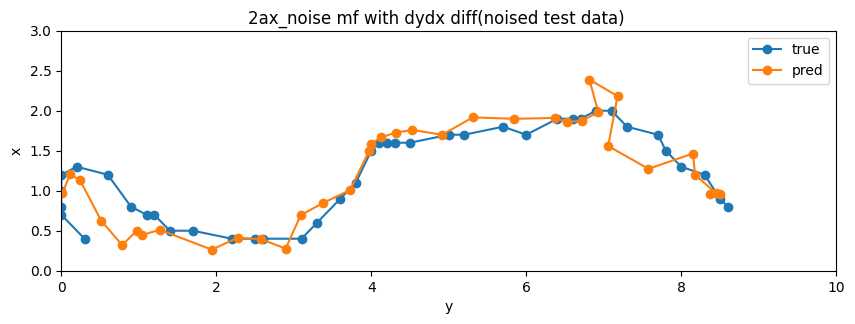

In [12]:
# titles = [
#     "predict by 2ax mf with noise",
#     "predict by 2ax mf with noise and distance",
#     "predict by 2ax mf with noise and route",
#     "predict by 2ax mf with noise and route diff",
# ]

titles = [
    "3ax mf",
    "3ax mf with distance",
    "3ax mf with dydx",
    "3ax mf with dydx diff",
    "2ax mf",
    "2ax mf with distance",
    "2ax mf with dydx",
    "2ax mf with dydx diff",
    "2ax_noise mf",
    "2ax_noise mf with distance",
    "2ax_noise mf with dydx",
    "2ax_noise mf with dydx diff",
]

# fig, ax = plt.subplots(1, 1, figsize=(10, 4))
# ax.plot(y[0, :, 1], y[0, :, 0], marker="o", label="true")
# for i, fig_data in enumerate(fig_datas):
#     x, y, y_hat = fig_data
#     figtitle = titles[i]    
#     ax.plot(y_hat[0, :, 1], y_hat[0, :, 0], marker="o", label=figtitle)

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 3)
# ax.set_xlabel("y")
# ax.set_ylabel("x")
# ax.legend()
# fig.suptitle(figtitle)
# plt.tight_layout()
# plt.show()

for i in range(len(fig_datas)):
    x, y, y_hat = fig_datas[i]
    figtitle = titles[i]

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 3)
    fig.suptitle(figtitle)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    ax.plot(y[0, :, 1], y[0, :, 0], marker="o", label="true")
    ax.plot(y_hat[0, :, 1], y_hat[0, :, 0], marker="o", label="pred")
    ax.legend()
    plt.subplots_adjust(top=0.91)  # topの値を小さくしてタイトルを下に寄せる
    plt.show()

    x, y, y_hat = fig_datas_noise[i]
    figtitle = titles[i] + "(noised test data)"

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 3)
    fig.suptitle(figtitle)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    ax.plot(y[0, :, 1], y[0, :, 0], marker="o", label="true")
    ax.plot(y_hat[0, :, 1], y_hat[0, :, 0], marker="o", label="pred")
    ax.legend()
    plt.subplots_adjust(top=0.91)  # topの値を小さくしてタイトルを下に寄せる
    plt.show()

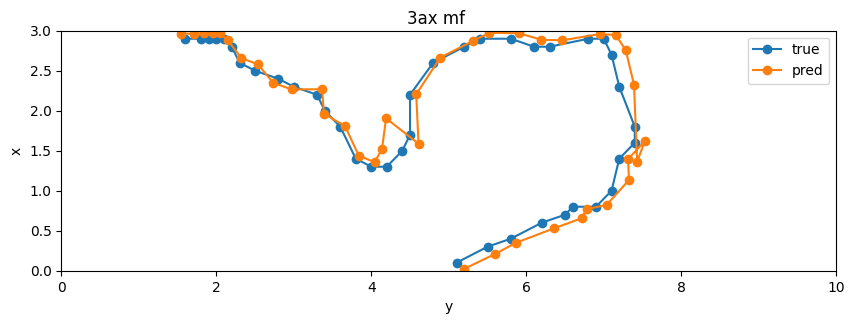

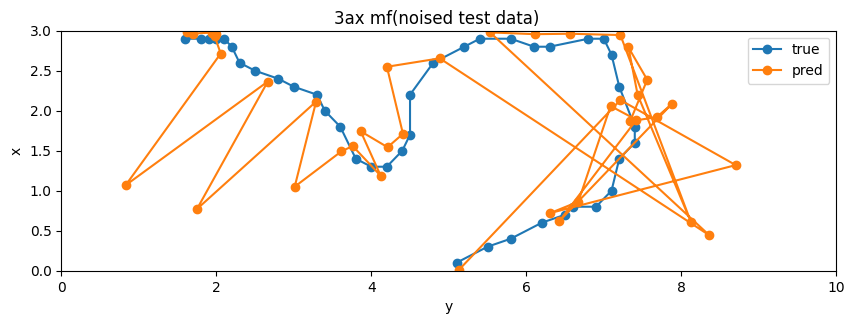

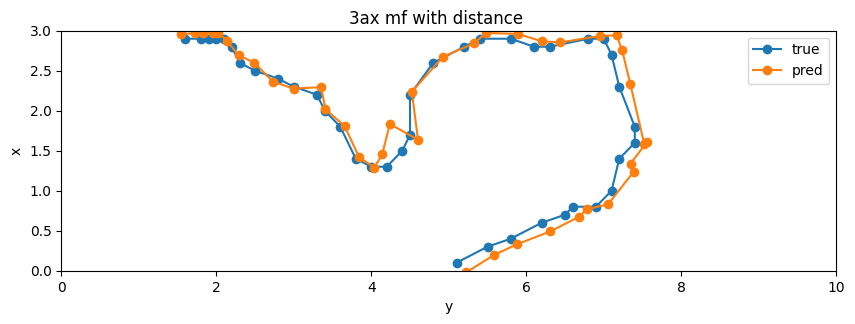

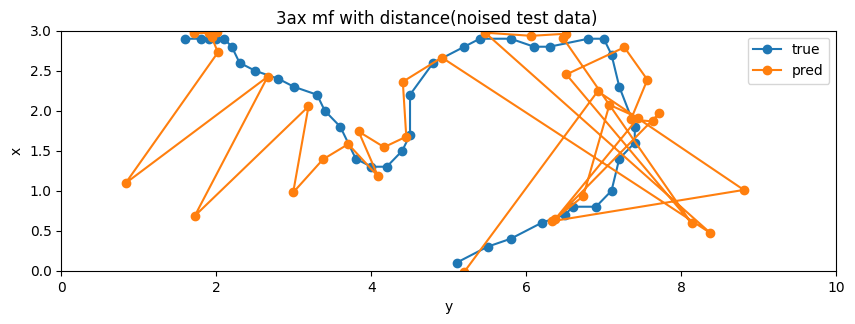

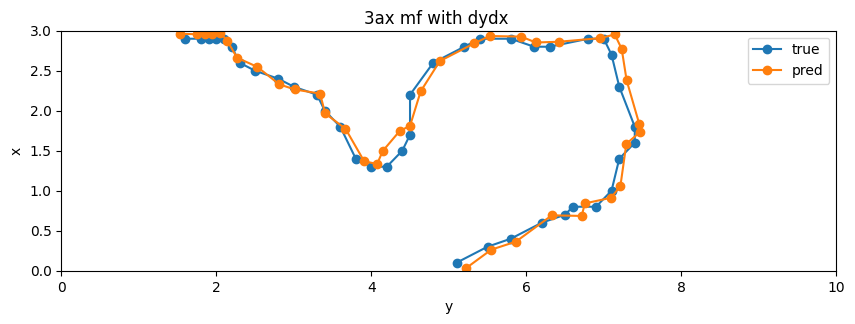

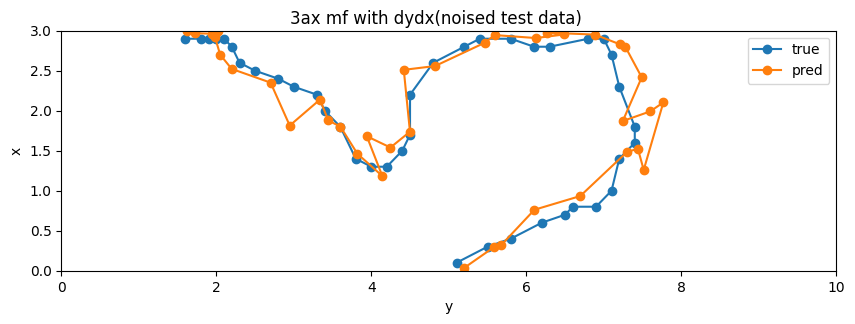

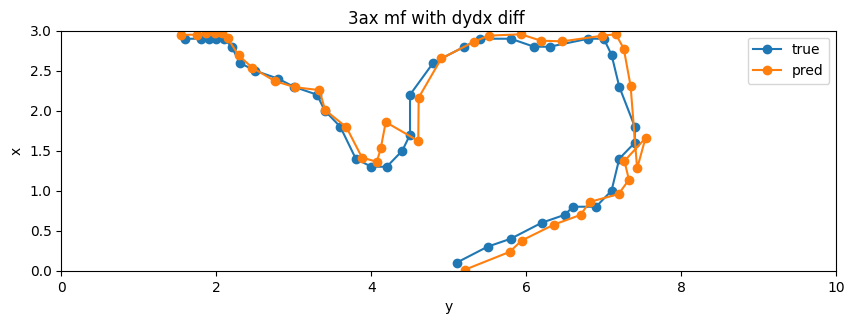

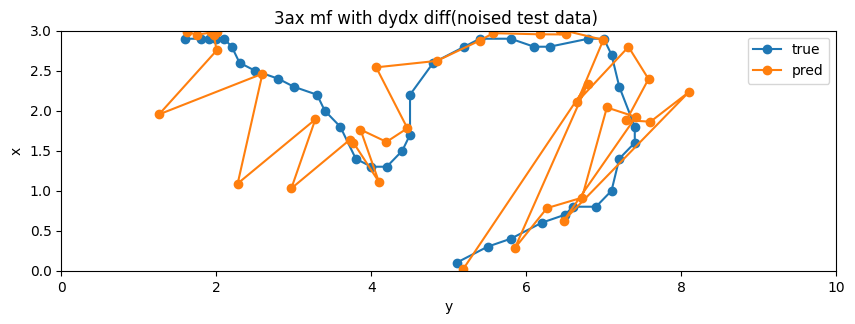

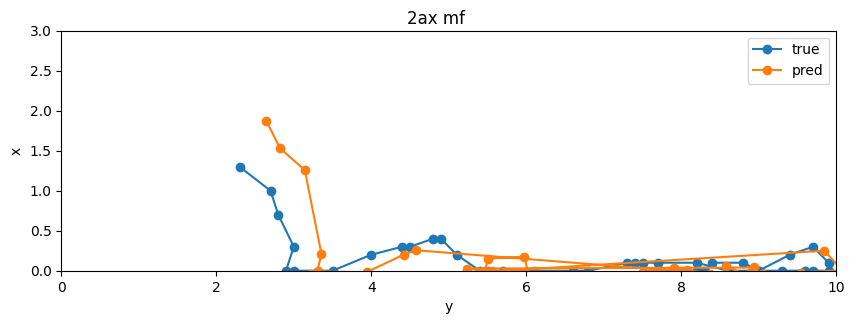

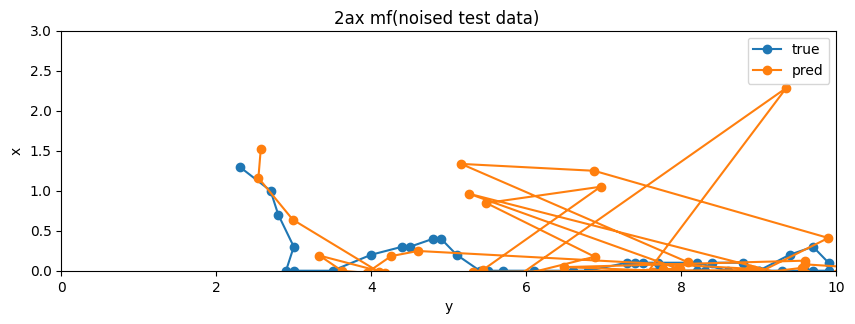

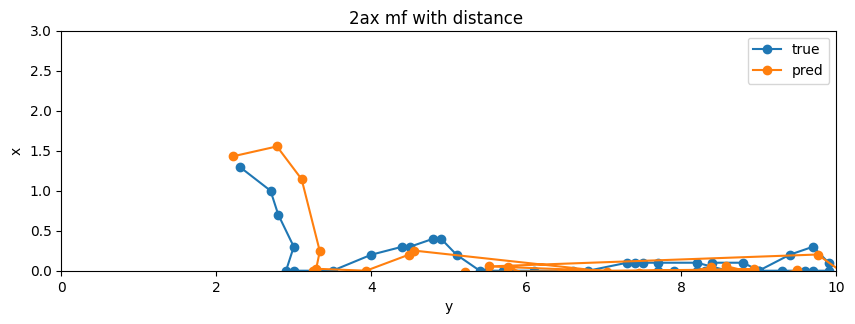

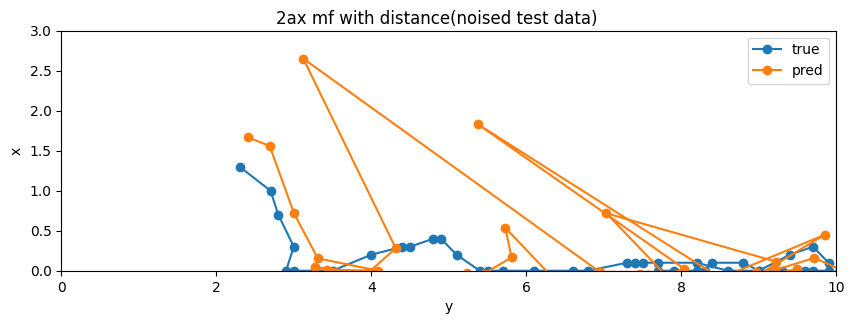

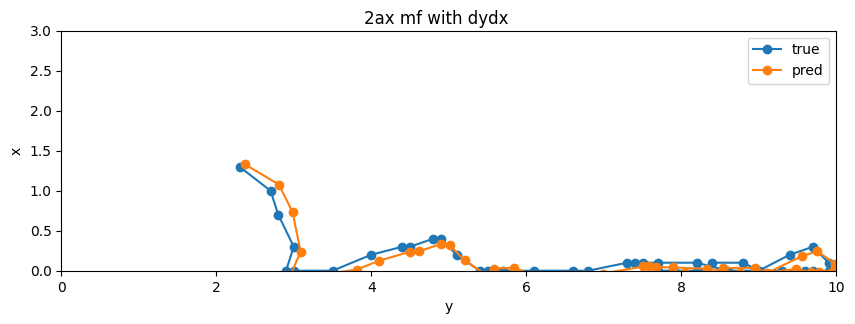

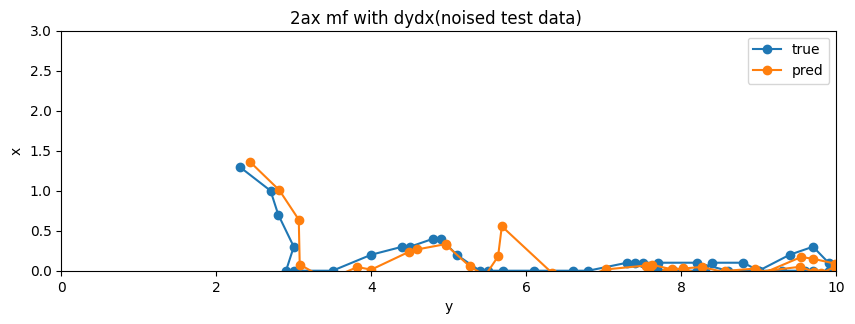

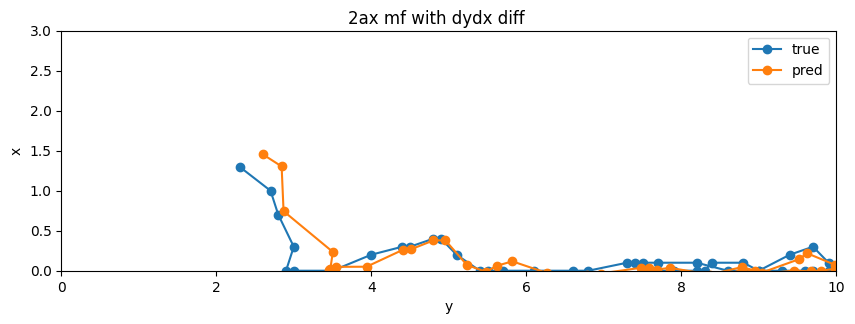

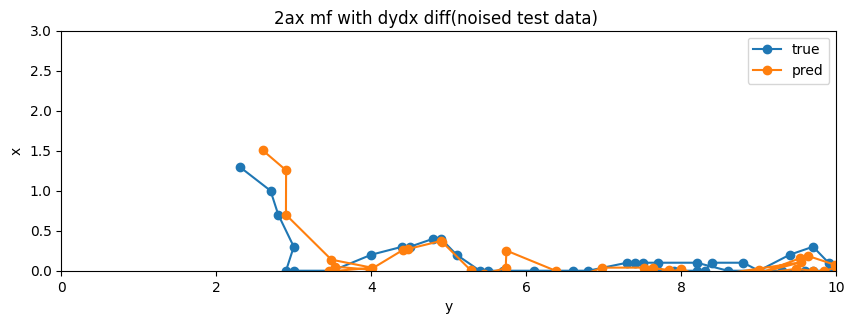

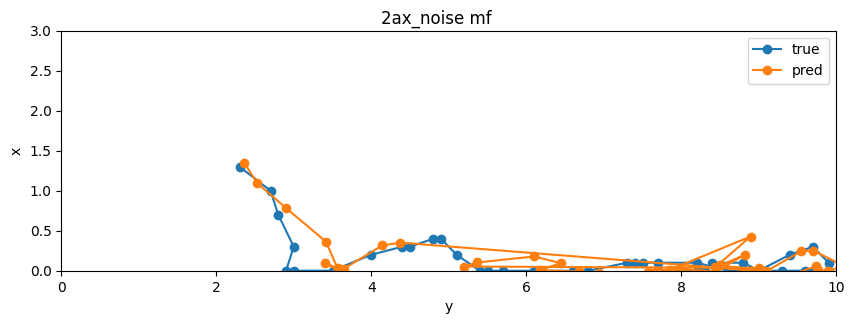

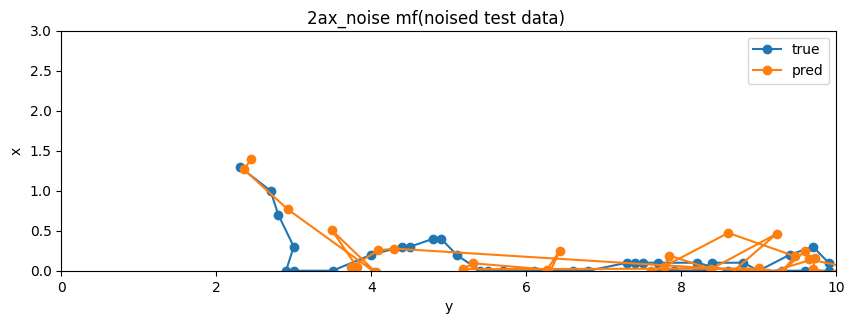

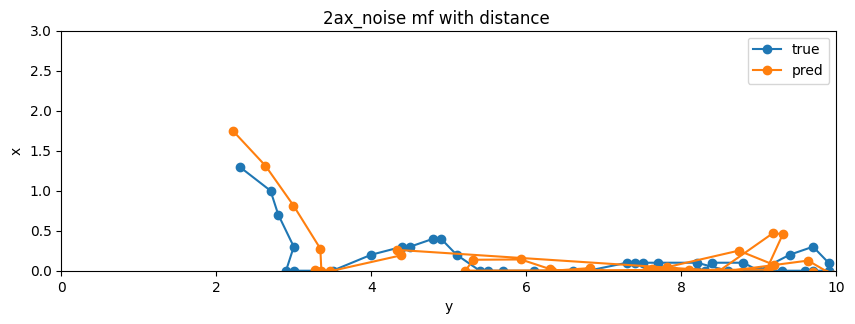

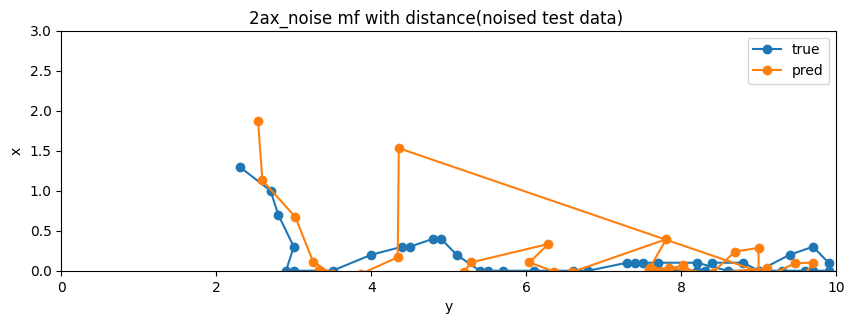

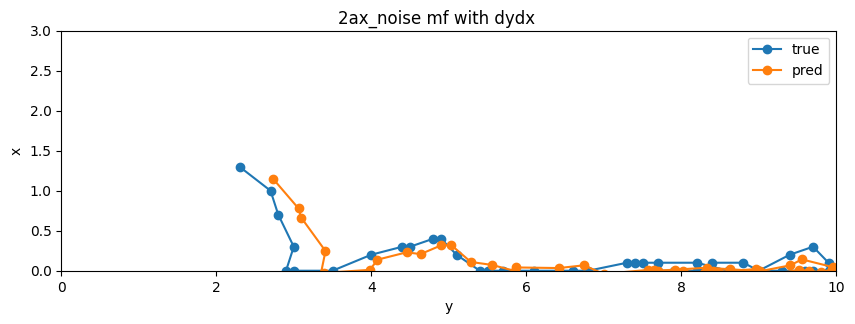

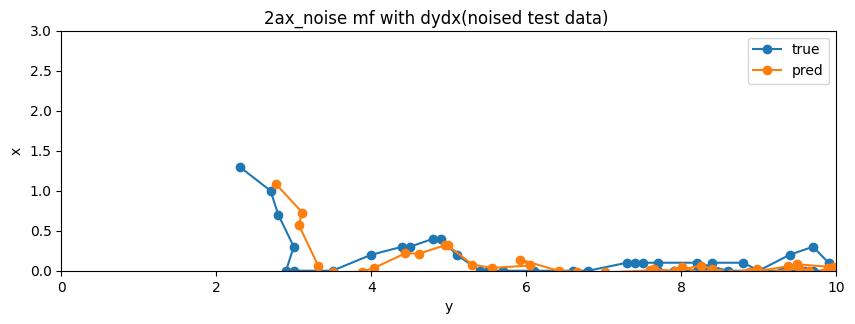

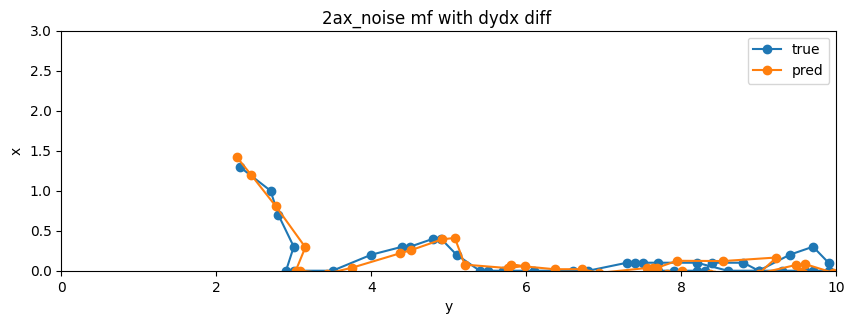

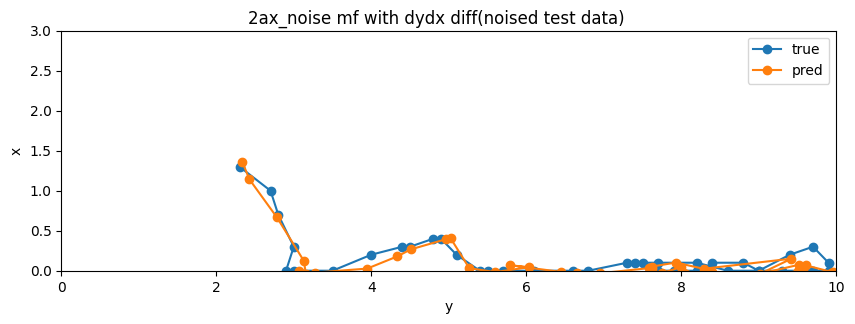

In [ ]:
# titles = [
#     "predict by 2ax mf with noise",
#     "predict by 2ax mf with noise and distance",
#     "predict by 2ax mf with noise and route",
#     "predict by 2ax mf with noise and route diff",
# ]

titles = [
    "3ax mf",
    "3ax mf with distance",
    "3ax mf with dydx",
    "3ax mf with dydx diff",
    "2ax mf",
    "2ax mf with distance",
    "2ax mf with dydx",
    "2ax mf with dydx diff",
    "2ax_noise mf",
    "2ax_noise mf with distance",
    "2ax_noise mf with dydx",
    "2ax_noise mf with dydx diff",
]

# fig, ax = plt.subplots(1, 1, figsize=(10, 4))
# ax.plot(y[0, :, 1], y[0, :, 0], marker="o", label="true")
# for i, fig_data in enumerate(fig_datas):
#     x, y, y_hat = fig_data
#     figtitle = titles[i]    
#     ax.plot(y_hat[0, :, 1], y_hat[0, :, 0], marker="o", label=figtitle)

# ax.set_xlim(0, 10)
# ax.set_ylim(0, 3)
# ax.set_xlabel("y")
# ax.set_ylabel("x")
# ax.legend()
# fig.suptitle(figtitle)
# plt.tight_layout()
# plt.show()

for i in range(len(fig_datas)):
    x, y, y_hat = fig_datas[i]
    figtitle = titles[i]

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 3)
    fig.suptitle(figtitle)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    ax.plot(y[0, :, 1], y[0, :, 0], marker="o", label="true")
    ax.plot(y_hat[0, :, 1], y_hat[0, :, 0], marker="o", label="pred")
    ax.legend()
    plt.subplots_adjust(top=0.91)  # topの値を小さくしてタイトルを下に寄せる
    plt.show()

    x, y, y_hat = fig_datas_noise[i]
    figtitle = titles[i] + "(noised test data)"

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 3)
    fig.suptitle(figtitle)
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    ax.plot(y[0, :, 1], y[0, :, 0], marker="o", label="true")
    ax.plot(y_hat[0, :, 1], y_hat[0, :, 0], marker="o", label="pred")
    ax.legend()
    plt.subplots_adjust(top=0.91)  # topの値を小さくしてタイトルを下に寄せる
    plt.show()